<a href="https://colab.research.google.com/github/jagrutimohanty/CrossDomain-Realtime-FineGrained-Twitter-Senitment-Analysis/blob/main/Take_the_Pulse_Datahub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **TAKE THE PULSE - DATAHUB**

## **Data Collection**

For our sentiment analysis we used movie review data from Rotten Tomatoes https://nlp.stanford.edu/sentiment/ 

This dataset contains the following files:
1. original_rt_snippets.txt contains 10,605 processed snippets from the original pool of Rotten Tomatoes HTML files. Please note that some snippet may contain multiple sentences.

2. **`dictionary.txt`** contains all phrases and their IDs, separated by a vertical line |

3. **`sentiment_labels.txt`** contains all phrase ids and the corresponding sentiment labels, separated by a vertical line.
Note that you can recover the 5 classes by mapping the positivity probability using the following cut-offs:

>*  [0.0, 0.2] =======> Very Negative 
*   (0.2, 0.4] =======> Negative
*   (0.4, 0.6] =======> Neutral
*   (0.6, 0.8] =======> Positive
*   (0.8, 1.0] =======> Very Positive

4. `SOStr.txt` and `STree.txt` encode the structure of the parse trees. 
STree encodes the trees in a parent pointer format. Each line corresponds to each sentence in the datasetSentences.txt file. The Matlab code of this paper will show you how to read this format if you are not familiar with it.

5. `datasetSentences.txt` contains the sentence index, followed by the sentence string separated by a tab. These are the sentences of the train/dev/test sets.

6. `datasetSplit.txt` contains the sentence index (corresponding to the index in datasetSentences.txt file) followed by the set label separated by a comma:
	1 = train
	2 = test
	3 = dev

The files in bold are relevant to our project and these were downloaded and uploaded to a shared drive linked to this notebook. Since we're interested in predicting sentiment analysis on Twitter, we opted to use **`dictionary.txt`** without the sentence context, this file contains phrases and their corresponding ids, these ids are then mapped to sentiment values in **`sentiment_labels.txt`**


These two files are loaded into our dataframe and then merged on the phrase id as shown below

In [ ]:
import os
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
DIR = '/content/drive/Shareddrives/255/Project'
if os.getcwd() != DIR:
  os.chdir(DIR)

data = pd.read_csv('./cleaned_data/dictionary.csv')
sentiment = pd.read_csv('./cleaned_data/sentiment_labels.txt', sep="|")
combined = pd.merge(data, sentiment, how='inner', left_on='id', right_on='phrase ids')
df = combined[['phrase', 'sentiment values']]

In [ ]:
pd.set_option('display.max_colwidth', -1)
df.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,phrase,sentiment values
73683,casting Shatner as a legendary professor and Kunis as a brilliant college student -- where 's Pauly Shore as the rocket scientist ?,0.31944
160705,"the notion that a strong , unified showing among Germany and Eastern European Jews might have changed 20th-Century history is undermined by Ahola 's inadequate performance",0.33333
117516,make pta proud yet director muccino 's characters are less worthy of puccini,0.34722
118176,manages to infuse the rocky path to sibling reconciliation with flashes of warmth and gentle humor,0.76389
144371,so much as that it hits close to home while engaging in such silliness as that snake-down-the-throat business and the inevitable shot of Schwarzenegger,0.41667


We'll run a mapping function over the sentiment values to recover our five classes

In [ ]:
def assign_sentiment(val):
  if val <= 0.2:
    return 0
  elif val <= 0.4:
    return 1
  elif val <= 0.6:
    return 2
  elif val <= 0.8:
    return 3
  return 4

labels = list(map(assign_sentiment, df['sentiment values'].to_numpy()))
df = df.assign(labels=labels)
df.sample(5)

,phrase,sentiment values,labels
2473,'s hope for popular cinema yet,0.63889,3
177603,wants to see a comedy about shoddy airport security,0.44444,2
38123,The Greatest Musicians,0.69444,3
85402,far from being a bow-wow,0.61111,3
144024,smeary,0.34722,1


## **Data Pre-Processing**

We're in a unique position since we'll need to apply different pre-processing steps to different parts of our data. The training data from Rotten Tomatoes is in better shape for sentiment analysis since it was prepared for that task in mind, the tweets that we'll evaluate in test time will however require more cleaning as we'll see later



The first step was to remove invalid phrases, basically phrases for which sentiment analysis does not make sense, so we removed phrases that were just punctuations and also the non-English phrases since the encoding we'll use for our model is pretrained on an English corpus.

To filter out non-English reviews we used a python library langdetect

In [ ]:
!pip install langdetect
from langdetect import detect, DetectorFactory

     |████████████████████████████████| 983kB 17.2MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=6f8b6270e3665038a94bd8574495f3e55fa98c8afd585a67edb7f0b942573170
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
# WARNING: This cell takes long to run even on GPU and High RAM Runtimes
from string import digits

DetectorFactory.seed = 0

def remove_invalid_phrases(s):
  try:
    is_en = detect(s) == 'en'
    if not s.strip(string.punctuation):
      return False
    return is_en
  except:
    return False

df = df[df['phrase'].apply(remove_invalid_phrases).to_list()]

We then remove all the unnecessary whitespace and at this point our data is in pretty good shape to be used. 

> At this point it'll be important to note that we're using SentenceBERT https://www.sbert.net/ a pretrained neural network that has very thorough preprocessing so additional preprocessing would have not been necessary. This is also important because SentenceBERT works with sentences and phrases and therefore takes the context of all the words into account, including stop words that are typically removed at this stage for most models. Therefore no stop words removal or lemmatization was done on the data




In [ ]:
def preprocess_phrase(s):
  s = s.strip()
  s = " ".join(s.split())
  return s

df['phrase'] = df['phrase'].apply(preprocess_phrase)

In [ ]:
df.sample(5)

,phrase,sentiment values,labels
111248,it tries too hard,0.55556,2
89633,"from home , but your ego",0.51389,2
127622,of serious athletes,0.52778,2
43378,"These are lives worth watching , paths worth following .",0.86111,4
172491,to take movies by storm,0.55556,2


## **Data Exploration**

Let's take a look at the distribution of our data across the five sentiment classes

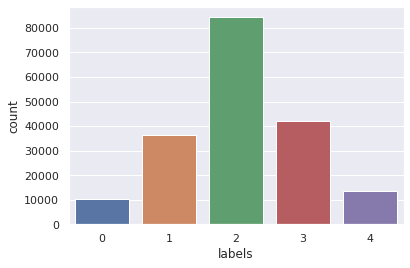

In [ ]:
import seaborn as sns

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="labels", data=df)

This graph shows us that there are a lot more phrases classified as neutral and far fewer phrases classified on either extremes. The sentiment values at a glance seem to follow a normal distribution with the mean being somewhere in the range [0.4, 0.6]

This also tells us that we should consider frequencies when training our classifier since an unbiased classifier is bound to do better on the neutral phrases that appear much more frequently in the text

Our end goal is to learn fine grained sentiment analysis from the phrases in this dataset and apply that to tweets on Twitter about movie hashtags, we therfore should also do some comparison on the length of phrases in our training corpus


Mean Character Count:  50.80067075261444 



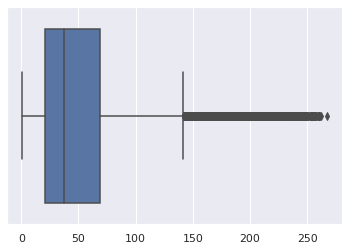

In [ ]:
char_count = df['phrase'].apply(lambda s: len(list(s))).to_numpy()
sns.set_theme(style="darkgrid")
print("Mean Character Count: ", np.mean(char_count), "\n")
ax = sns.boxplot(x=char_count)

This is just about what we want for our training data, the mean character count is ~50 characters which is not too far off from the average character length of a tweet on Twitter, 33 charachters with the new 280 character limit 

https://techcrunch.com/2018/10/30/twitters-doubling-of-character-count-from-140-to-280-had-little-impact-on-length-of-tweets/#:~:text=The%20most%20common%20length%20of,a%20tweet%20is%2033%20characters.

## **Data Encoding**

We can now proceed to encode our phrases into vectors. We'll user Sentence BERT as mentioned earlier. This mode comes pretrained and packaged in the library sentence-transformers

SentenceTransformers is a Python framework for state-of-the-art sentence and text embeddings. The initial work is described in our paper Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks.

In [ ]:
# WARNING: This cell takes long to run even on GPU and High RAM Runtimes
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
encodings = sbert_model.encode(df['phrase'].to_numpy())

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.3.9)


We'll save the encodings into a csv file on our shared drive and with that our training data is ready for use!

In [ ]:
np.savetxt('./cleaned_data/rt_bert_encodings.csv', encodings, delimiter=',')